# Gulf Guinea Toy
**Mapping CDR signals within Gulf Guinea Toy**: This notebook maps the fraction of CO2 uptake occuring within a finite regional domain using the global atlas estimates of uptake.

## Import Libraries

Load the Python packages for data handling, ROMS-Tools grids, atlas utilities, and helper functions.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr

import roms_tools as rt

import cdr_atlas
import parsers
import utils

/Users/mclong/miniconda3/envs/atlas-calcs/lib/python3.13/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Configure Inputs and Define the Regional Grid

In [2]:
domain_name = "test-dummy"
grid_yaml = "tests/_grid.yml"
injection_year = 1999
injection_month = 1
n_test = 3
dask_cluster_kwargs = {
    "account": "m4632",
    "queue_name": "premium",
    "scheduler_file": None,
}

In [3]:
# Parameters
domain_name = "Gulf Guinea Toy"
grid_yaml = "cson_forge/blueprints/cson_roms-marbl_v0.1_gulf-guinea-toy/_grid.yml"
injection_year = 1999
injection_month = 1
n_test = 2
dask_cluster_kwargs = {
    "account": "m4632",
    "queue_name": "premium",
    "n_nodes": 1,
    "n_tasks_per_node": 128,
    "wallclock": "06:00:00",
    "scheduler_file": None,
}


## Configure Inputs and Define the Regional Grid

Set the domain name, grid YAML, injection settings, and optional `n_test` parameter, then load the ROMS-Tools grid. The grid defines the spatial boundaries of the regional domain and is plotted for a quick visual check.

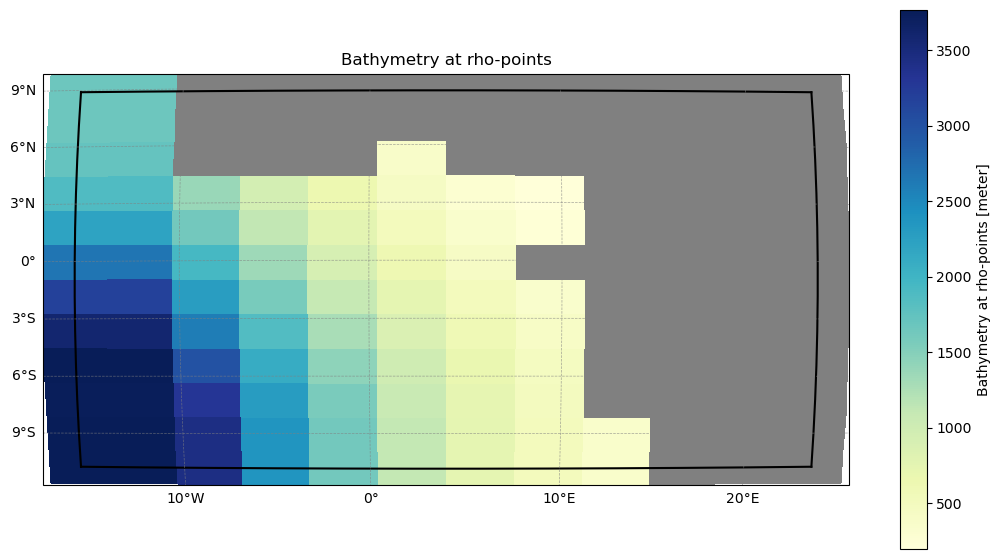

In [4]:
model_grid = parsers.load_roms_tools_object(grid_yaml)
model_grid.plot()

## Create Analyzer and Identify Overlapping Polygons

Select the atlas dataset spec from `cdr_atlas.DATASET_REGISTRY` and initialize `AtlasModelGridAnalyzer`. The analyzer:

1. **Computes a convex hull** of the regional grid using `model_grid.ds.lat_u`/`lon_u`
2. **Performs point‑in‑polygon tests** against the atlas grid
3. **Extracts unique polygon IDs** that overlap the regional domain
4. **Builds a polygon mask** for within‑domain points

This convex‑hull approach captures non‑rectangular domains more accurately than a bounding box. 

Found 19 unique polygon IDs within model grid boundaries
Polygon IDs: [  5.  15.  20.  21.  64.  70.  73.  85. 103. 110. 113. 122. 129. 145.
 358. 487. 575. 600. 632.]


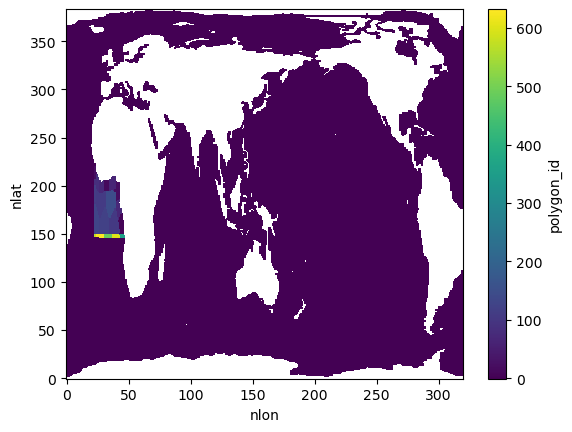

In [5]:
atlas_data = cdr_atlas.DATASET_REGISTRY["oae-efficiency-map_atlas-v0"]

# Create AtlasModelGridAnalyzer instance
analyzer = cdr_atlas.AtlasModelGridAnalyzer(model_grid, atlas_data)

# Get polygon IDs within model grid boundaries
print(f"Found {len(analyzer.polygon_ids_in_bounds)} unique polygon IDs within model grid boundaries")
print(f"Polygon IDs: {analyzer.polygon_ids_in_bounds[:100]}..." if len(analyzer.polygon_ids_in_bounds) > 100 else f"Polygon IDs: {analyzer.polygon_ids_in_bounds}")

analyzer.polygon_id_mask.plot(vmin=-1, vmax=analyzer.polygon_id_mask.max())

## Start Dask Cluster and Test a Single Polygon

A Dask cluster is created (if available) for distributed operations. Then we compute cumulative CO2 uptake for a single polygon using `n_test=3`, which limits the analysis to the first three files in the atlas sequence.

The integration:

1. **Ensures cached files** via the dataset spec
2. **Calculates the additional CO2 flux** (`FG_CO2 - FG_ALT_CO2`)
3. **Integrates over space and time** using:
   - Area weighting with `TAREA`
   - Time weighting with days per month
   - Spatial masking to the regional domain
4. **Computes cumulative integrals** over elapsed time

The outputs include total uptake, uptake within the regional grid, and the fraction captured.

In [6]:
cluster = utils.dask_cluster(**dask_cluster_kwargs)
cluster

2026-01-18 16:45:21 - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy


/Users/mclong/miniconda3/envs/atlas-calcs/lib/python3.13/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52121 instead
  warnings.warn(
2026-01-18 16:45:21 - INFO - State start


2026-01-18 16:45:21 - INFO -   Scheduler at:     tcp://127.0.0.1:52122


2026-01-18 16:45:21 - INFO -   dashboard at:  http://127.0.0.1:52121/status


2026-01-18 16:45:21 - INFO - Registering Worker plugin shuffle


2026-01-18 16:45:21 - INFO -         Start Nanny at: 'tcp://127.0.0.1:52125'


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
2026-01-18 16:45:21 - INFO -         Start Nanny at: 'tcp://127.0.0.1:52127'


2026-01-18 16:45:21 - INFO -         Start Nanny at: 'tcp://127.0.0.1:52129'


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


2026-01-18 16:45:21 - INFO -         Start Nanny at: 'tcp://127.0.0.1:52131'


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


2026-01-18 16:45:22 - INFO - Register worker addr: tcp://127.0.0.1:52134 name: 1


2026-01-18 16:45:22 - INFO - Starting worker compute stream, tcp://127.0.0.1:52134


2026-01-18 16:45:22 - INFO - Starting established connection to tcp://127.0.0.1:52141


2026-01-18 16:45:22 - INFO - Register worker addr: tcp://127.0.0.1:52136 name: 2


2026-01-18 16:45:22 - INFO - Starting worker compute stream, tcp://127.0.0.1:52136


2026-01-18 16:45:22 - INFO - Starting established connection to tcp://127.0.0.1:52145


2026-01-18 16:45:22 - INFO - Register worker addr: tcp://127.0.0.1:52135 name: 0


2026-01-18 16:45:22 - INFO - Starting worker compute stream, tcp://127.0.0.1:52135


2026-01-18 16:45:22 - INFO - Starting established connection to tcp://127.0.0.1:52144


2026-01-18 16:45:22 - INFO - Register worker addr: tcp://127.0.0.1:52137 name: 3


2026-01-18 16:45:22 - INFO - Starting worker compute stream, tcp://127.0.0.1:52137


2026-01-18 16:45:22 - INFO - Starting established connection to tcp://127.0.0.1:52140


2026-01-18 16:45:22 - INFO - Receive client connection: Client-c103f5e6-f4c7-11f0-9c45-26da8a241958


2026-01-18 16:45:22 - INFO - Starting established connection to tcp://127.0.0.1:52146


Local cluster running at http://127.0.0.1:52121/status


In [7]:
%%time
# Integrate FG_CO2 for polygon 000 using the first 3 files in the sequence
results = analyzer.integrate_fg_co2_polygon_by_id(
    polygon_id=analyzer.polygon_ids_in_bounds[-1],
    injection_year=injection_year,
    injection_month=injection_month,
    n_test=3,
)

print("FG_CO2 Integration Results:")
print(f"  Total integrated FG_CO2: {results['total'].values[-1]:.2e}")
print(f"  Within model grid: {results['within_grid'].values[-1]:.2e}")
print(f"  Fraction within grid: {results['fraction'].values[-1]:.2%}")

FG_CO2 Integration Results:
  Total integrated FG_CO2: 7.85e+10
  Within model grid: 6.63e+09
  Fraction within grid: 8.44%
CPU times: user 2.5 s, sys: 285 ms, total: 2.79 s
Wall time: 6.51 s


## Integrate CO<sub>2</sub> Flux for All Overlapping Polygons

Compute cumulative CO2 uptake for every polygon that overlaps the regional domain. Results are concatenated along `polygon_id`, yielding a dataset with dimensions `(polygon_id, elapsed_time)`.

In [8]:
%%time
ds = analyzer.integrate_fg_co2_polygons_within_boundaries(
    injection_year=injection_year,
    injection_month=injection_month,
    n_test=n_test,
)   
ds

CPU times: user 4.53 s, sys: 392 ms, total: 4.92 s
Wall time: 8.3 s


<xarray.Dataset> Size: 400B
Dimensions:                 (polygon_id: 2, elapsed_time: 2)
Coordinates: (12/35)
    time                    (elapsed_time) object 16B 0347-02-01 00:00:00 034...
    days_in_norm_year       timedelta64[ns] 8B 365 days
    grav                    float64 8B 980.6
    omega                   float64 8B 7.292e-05
    radius                  float64 8B 6.371e+08
    cp_sw                   float64 8B 3.996e+07
    ...                      ...
    sflux_factor            float64 8B 0.1
    nsurface_t              float64 8B 8.61e+04
    nsurface_u              float64 8B 8.297e+04
  * polygon_id              (polygon_id) float64 16B 5.0 15.0
    injection_date          object 8B 1999-01-01 00:00:00
  * elapsed_time            (elapsed_time) timedelta64[ns] 16B 00:00:00 31 days
Data variables:
    total                   (polygon_id, elapsed_time) float64 32B 5.289e+09 ...
    within_grid             (polygon_id, elapsed_time) float64 32B 5.212e+09 ...
    fraction                (polygon_id, elapsed_time) float64 32B 0.9855 ......

## Visualize Fraction of Uptake within the Regional Domain

Map the fraction of CO2 uptake captured within the regional domain for each polygon. The map highlights where a larger share of uptake falls inside the regional grid, helping assess how well the regional domain captures atlas signals.

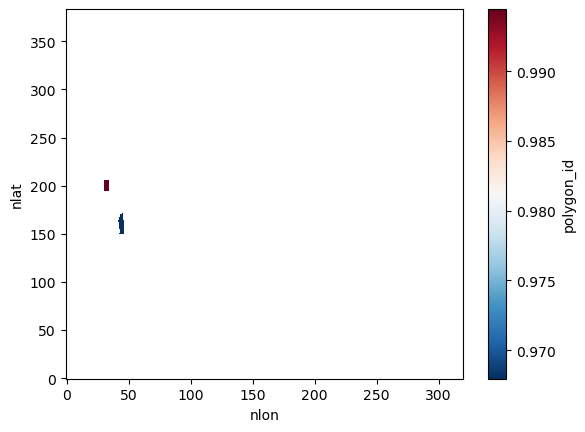

In [9]:
analyzer.set_field_within_boundaries(ds.fraction.isel(elapsed_time=-1)).plot(cmap="RdBu_r")


In [10]:
# check if LocalCluster is running and shutdown
if cluster.local_cluster:
    cluster.shutdown()

2026-01-18 16:45:37 - INFO - Closing Nanny at 'tcp://127.0.0.1:52125'. Reason: nanny-close


2026-01-18 16:45:37 - INFO - Nanny asking worker to close. Reason: nanny-close


2026-01-18 16:45:37 - INFO - Closing Nanny at 'tcp://127.0.0.1:52127'. Reason: nanny-close


2026-01-18 16:45:37 - INFO - Nanny asking worker to close. Reason: nanny-close


2026-01-18 16:45:37 - INFO - Closing Nanny at 'tcp://127.0.0.1:52129'. Reason: nanny-close


2026-01-18 16:45:37 - INFO - Nanny asking worker to close. Reason: nanny-close


2026-01-18 16:45:37 - INFO - Closing Nanny at 'tcp://127.0.0.1:52131'. Reason: nanny-close


2026-01-18 16:45:37 - INFO - Nanny asking worker to close. Reason: nanny-close


2026-01-18 16:45:37 - INFO - Nanny at 'tcp://127.0.0.1:52131' closed.


2026-01-18 16:45:37 - INFO - Nanny at 'tcp://127.0.0.1:52127' closed.


2026-01-18 16:45:37 - INFO - Nanny at 'tcp://127.0.0.1:52125' closed.


2026-01-18 16:45:37 - INFO - Nanny at 'tcp://127.0.0.1:52129' closed.
